# Data and Models

So far we've seen a variety of different models on different datasets for different tasks (regression/classification) and we're going to learn about more algorithms in subsequent lessons. 
But we've ignored a fundamental concept about data and modeling: quality and quantity. 
In a nutshell, a machine learning model consumes input data and produces predictions. 
The quality of the predictions directly corresponds to the quality and quantity of data you train the model with; garbage in, garbage out.

<img src="figures/nutshell.png" width=500>

# Set Up

We're going to go through all the concepts with concrete code examples. We'll first synthesize some data to train our models on. The task is to determine whether a tumor will be benign (harmless) or malignant (harmful) based on leukocyte (white blood cells) count and blood pressure. 

In [1]:
# Now import the libraries
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [3]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="data/tumors.csv",
    reduced_data_file="data/tumors_reduced.csv",
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-3,
    num_epochs=100,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

Using CUDA: False


# Data

In [4]:
import re
import urllib

In [5]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


In [6]:
def plot_tumors(df):
    i = 0; colors=['r', 'b']
    for name, group in df.groupby("tumor"):
        plt.scatter(group.leukocyte_count, group.blood_pressure, edgecolors='k',
                   color=colors[i]); i += 1
    plt.xlabel('leukocyte count')
    plt.ylabel('blood pressure')
    plt.legend(['0 - benign', '1 - malignant'], loc="upper right")
    plt.show()

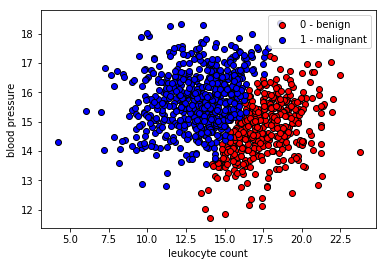

In [7]:
# Plot data
plot_tumors(df)

In [8]:
# Convert to PyTorch tensors
X = df.as_matrix(columns=['leukocyte_count', 'blood_pressure'])
y = df.as_matrix(columns=['tumor'])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

In [9]:
# Shuffle data
shuffle_indices = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 750 train samples and 250 test samples.


# Model

Let's fit a model on this synthetic data.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [11]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [12]:
# Initialize model
model = MLP(input_dim=len(df.columns)-1, 
            hidden_dim=args.num_hidden_units, 
            output_dim=len(set(df.tumor)))

In [13]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) 

In [14]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [15]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 4.5682 | accuracy: 38.7%
epoch: 20 | loss: 0.9316 | accuracy: 61.3%
epoch: 40 | loss: 0.3911 | accuracy: 95.2%
epoch: 60 | loss: 0.2875 | accuracy: 98.1%
epoch: 80 | loss: 0.1876 | accuracy: 98.3%


In [16]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [17]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 98.7%, test acc: 98.8%


In [18]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

We're going to plot a white point, which we know belongs to the malignant tumor class. Our well trained model here would accurately predict that it is indeed a malignant tumor!

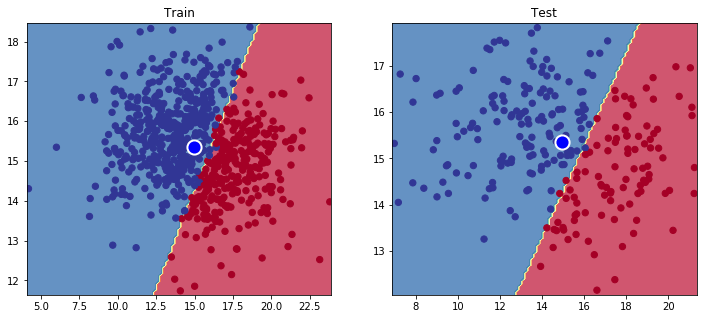

In [19]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.show()

Great! We received great performances on both our train and test data splits. We're going to use this dataset to show the importance of data quality and quantity.

# Data Quality and Quantity

Let's remove some training data near the decision boundary and see how robust the model is now.

In [20]:
# Raw reduced data
df_reduced = pd.read_csv(args.reduced_data_file, header=0)
df_reduced.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


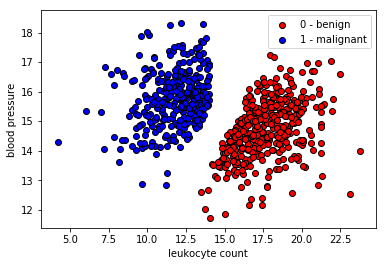

In [21]:
# Plot data
plot_tumors(df_reduced)

In [22]:
# Convert to PyTorch tensors
X = df_reduced.as_matrix(columns=['leukocyte_count', 'blood_pressure'])
y = df_reduced.as_matrix(columns=['tumor'])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

In [23]:
# Shuffle data
shuffle_indices = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 540 train samples and 180 test samples.


In [24]:
# Initialize model
model = MLP(input_dim=len(df_reduced.columns)-1, 
            hidden_dim=args.num_hidden_units, 
            output_dim=len(set(df_reduced.tumor)))

In [25]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) 

In [26]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0} | loss: {1:.4f} | accuracy: {2:.1f}%".format(t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 0 | loss: 0.9338 | accuracy: 52.0%
epoch: 20 | loss: 0.2829 | accuracy: 100.0%
epoch: 40 | loss: 0.1318 | accuracy: 100.0%
epoch: 60 | loss: 0.0745 | accuracy: 100.0%
epoch: 80 | loss: 0.0506 | accuracy: 100.0%


In [27]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [28]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 100.0%, test acc: 100.0%


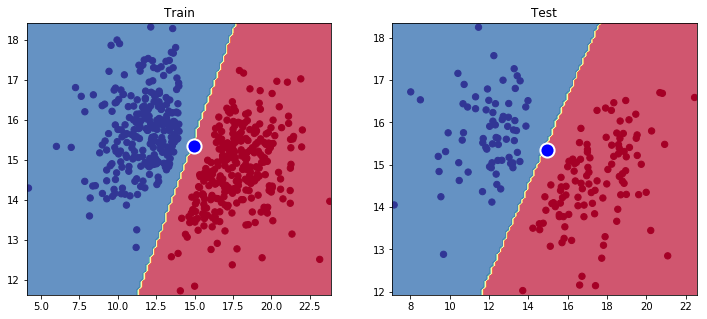

In [29]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.show()

This is a very scary but highly realistic scenario. Based on our reduced synthetic dataset, we have achieved a model that generalized really well on the test data. But when we ask for the prediction for the same white point earlier (which we known as a tumor), the prediction is now a benign tumor. We would have completely missed the tumor.

**MODELS ARE NOT CRYSTAL BALLS** 
It's so important that before any machine learning, we really look at our data and ask ourselves if it is truly representative for the task we want to solve. The model itself may fit really well and generalize well on your data but if the data is of poor quality to begin with, the model cannot be trusted.

# Models

Once you are confident that your data is of good quality and quantity, you can finally start thinking about modeling. The type of model you choose depends on many factors, including the task, type of data, complexity required, etc.

<img src="figures/models1.png" width=550>

So once you figure out what type of model your task needs, start with simple models and then slowly add complexity. You don’t want to start with neural networks right away because that may not be right model for your data and task. Striking this balance in model complexity is one of the key tasks of your data scientists. **simple models → complex models**